# Finding COVID-19 using Principal Component Analysis and Singular Value Decomposition

Analyzing COVID-19 data of different countries (US, China and Canada) by performing dimensionality reduction. This data provides information about the number cases recorded each day and number of deaths. The eigen values are determined using two methods - PCA and SVD.

In [ ]:
import pandas as pd
cases_raw = pd.read_csv(
    filepath_or_buffer='https://raw.githubusercontent.com/aps1070-2019/datasets/master/APS_COVID_Jan22.csv',
    index_col=0,
    thousands=','
)

In [ ]:
cases_raw.shape

(196, 733)

**Some Observations**

The graphs are plotted using normalized data, which means that the mean in equal to 0 and standard deviation is 1.

The plot for China shows that the number of cases were sgnificantly higher than the world average, in the earlier phases of the pandemic. But, the curve flattens down to 0, which means that the number of cases are close to the world average, in the later stages of the pandemic. On the other hand, plots for US and Canada show that the number was lower than the global average initially, with fluctuations in the later stages.

The curve going up indicates that the number of cases are rising higher than the global average and vice versa.
Since the mean is 0, negative values mean that the number of cases is lower compared to the world's average. The sign just indicates whether the number of cases are above or below the global average.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
# function for plotting the time series data for countries

cases_raw.columns = pd.to_datetime(cases_raw.columns)
def time_series_plots(data_frame, country_list):
  list_len = len(country_list)
  fig, ax = plt.subplots(list_len, figsize = (12,16))
  for i in range(0, list_len):
    ax[i].plot(data_frame.loc[country_list[i]], color = 'b')
    ax[i].set_title(('{}'.format(country_list[i])),fontsize = 14)
    ax[i].set(ylabel = 'Number of Covid Cases')
    fig.text(0.5, 0.09, 'Date', ha = 'center', va = 'center', fontsize = 10)
    # fig.text(0.05, 0.5, 'Number of Covid Cases', ha = 'center', va = 'center', rotation = 'vertical')

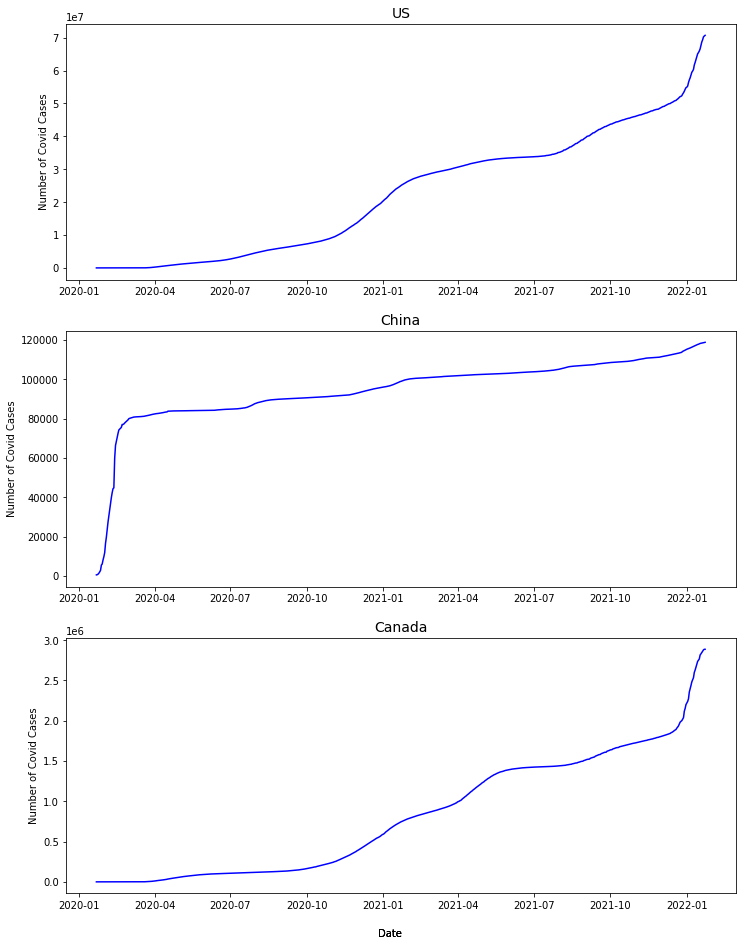

In [ ]:
# checking on non-standardized data
country_list = ['US', 'China', 'Canada']
time_series_plots(cases_raw, country_list)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# standardizing data and creating a new data frame with standardized data
cases_std_arr = StandardScaler().fit_transform(cases_raw)
cases_std = pd.DataFrame(data = cases_std_arr, columns = cases_raw.columns, index = cases_raw.index)

In [ ]:
# putting values of cases_raw dataframe as an array
cases_raw_arr = cases_raw.iloc[::].values

# checking mean, variance and standard deviation (of the first column) for standardized and non-standardized data
print('For non-standardized data:')
print('Mean:', cases_raw_arr[:,0].mean(), 'Variance:', cases_raw_arr[:,0].var(), 'Standard deviation:', (cases_raw_arr[:,0].var())**0.5)
print()
print('For standardized data:')
print('Mean:', cases_std_arr[:,0].mean(), 'Variance:', cases_std_arr[:,0].var(), 'Standard deviation:', (cases_std_arr[:,0].var())**0.5)

For non-standardized data:
Mean: 2.8418367346938775 Variance: 1524.2045762182424 Standard deviation: 39.04106269324956

For standardized data:
Mean: 1.8126090197961738e-17 Variance: 0.9999999999999999 Standard deviation: 0.9999999999999999


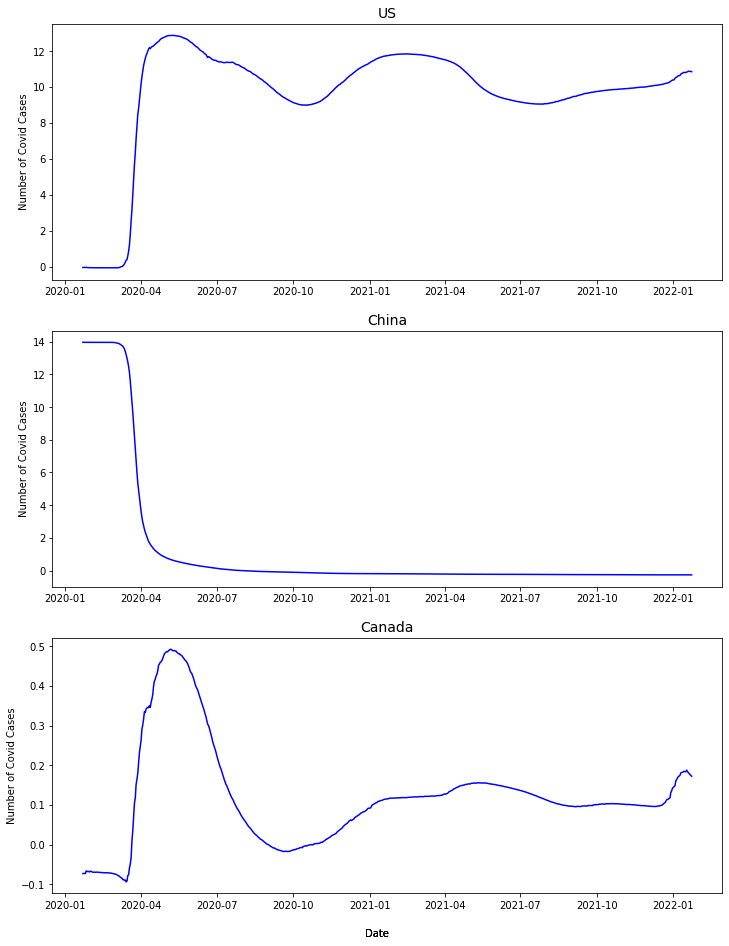

In [ ]:
# for standardized data
time_series_plots(cases_std, country_list)

## Principal Component Analysis

In [ ]:
covariance_mat = np.dot(cases_std.T, cases_std)/(cases_std.shape[0]-1)
df_cov = pd.DataFrame(data = covariance_mat)
# df_cov

In [ ]:
def get_sorted_eigen(df_cov):
  eigen_values, eigen_vectors = np.linalg.eigh(df_cov)
  # print(eigen_values)
  # print(eigen_vectors)

  # sorting eigenvalues and eigenvectors in descending order
  args = (eigen_values).argsort()[::-1]
  eigen_values = eigen_values[args]
  eigen_vectors = eigen_vectors[:, args]
  return eigen_values, eigen_vectors

In [ ]:
eigen_values, eigen_vectors = get_sorted_eigen(df_cov)

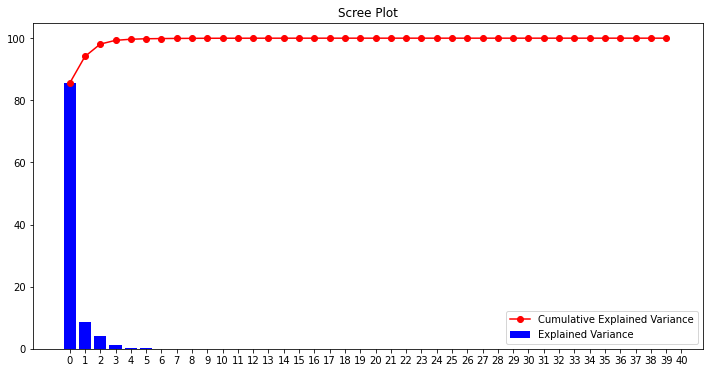

In [ ]:
# finding the explained variance and cummulative explained variance
eigen_value_sum = sum(eigen_values)
exp_variance = [(eigen_val/eigen_value_sum)*100 for eigen_val in eigen_values]
cum_variance = np.cumsum(exp_variance)
# print(cum_variance)


# scree plot
plt.figure(figsize = (12,6))
plt.bar(range(40), exp_variance[:40], color = 'b', label = 'Explained Variance')
plt.plot(cum_variance[:40], marker = 'o', color = 'r', label = 'Cumulative Explained Variance')
plt.xticks(np.arange(0,41,1))
plt.legend(loc = 'lower right')
plt.title('Scree Plot')
plt.show()

In [ ]:
# finding number of principal components needed for covering 98% variance

tr = np.where(cum_variance < 98)[0]
print('Number of Principal Components:',len(tr)+1)

Number of Principal Components: 3


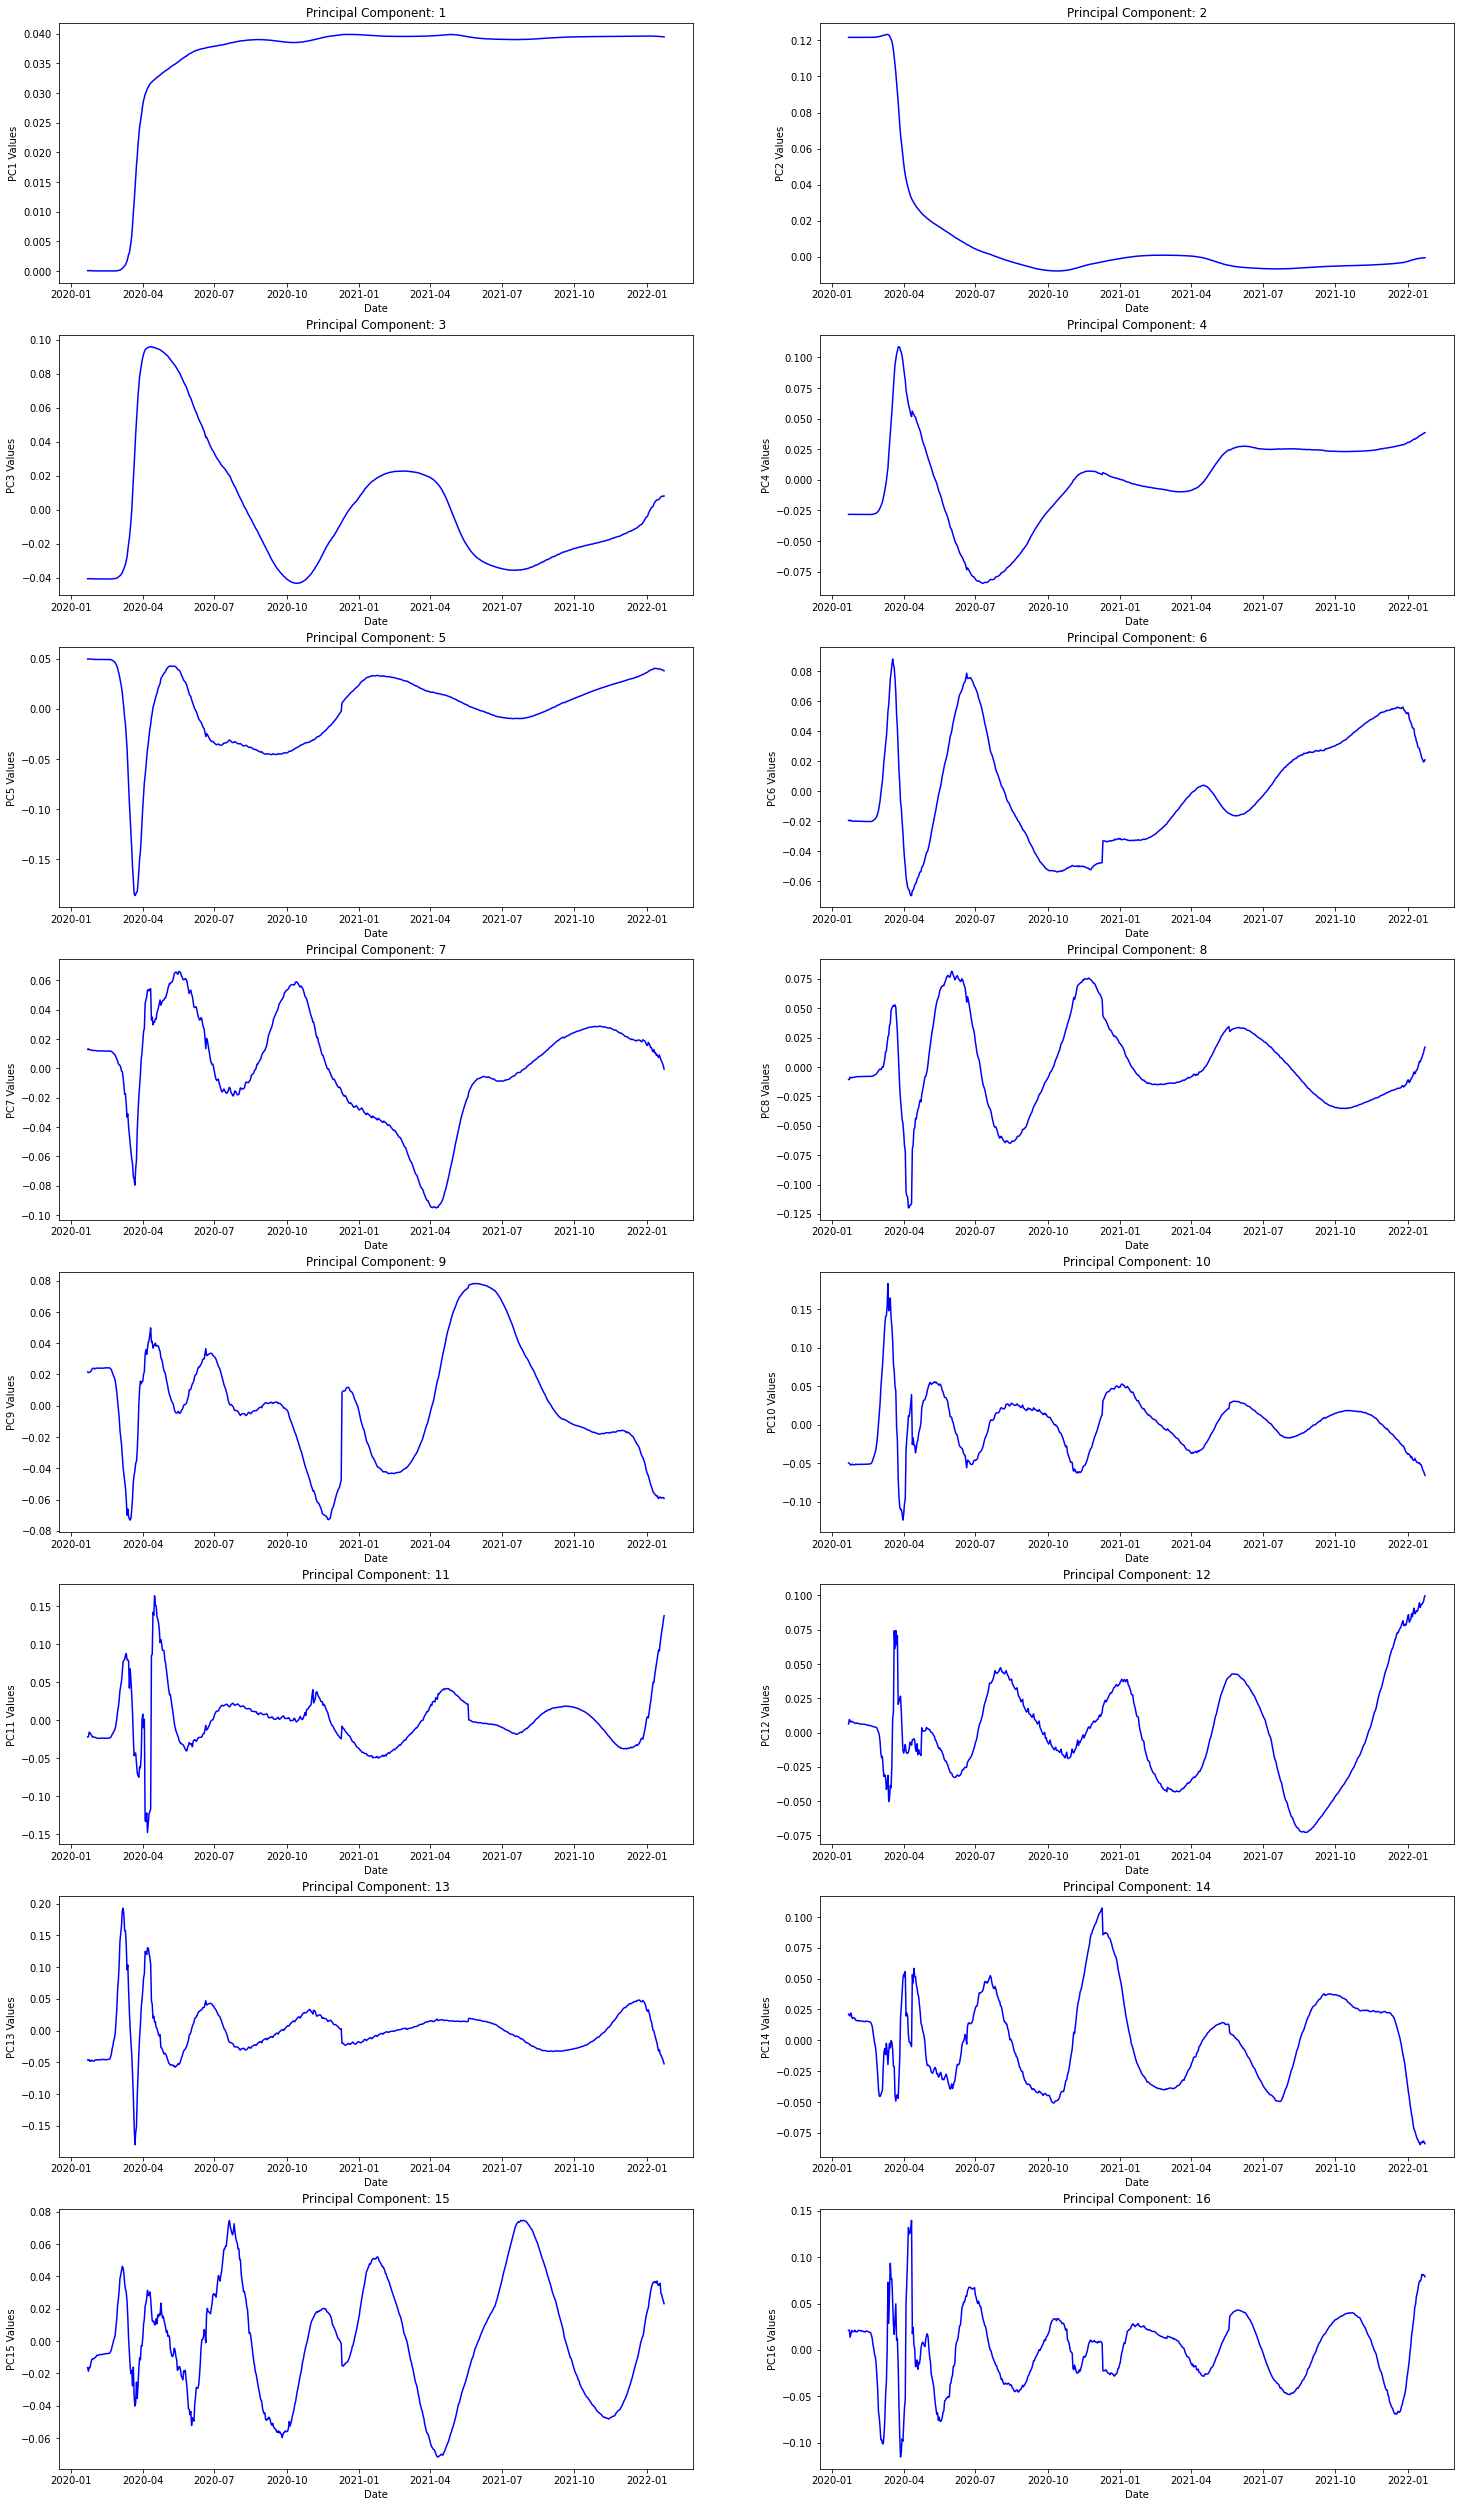

In [ ]:
# plotting the first 16 principal components as time series
fig, ax = plt.subplots(nrows = 8, ncols = 2, figsize = (25,45))
i = 0
for row in range(8):
  for col in range(2):
    ax[row,col].plot(cases_std.columns, eigen_vectors[:,i], color = 'b')
    # ax[row,col].plot(cases_std.columns, eigen_vectors[:,i], color = 'orange')
    ax[row,col].set_title('Principal Component: {}'.format(i+1))
    ax[row,col].set(xlabel = 'Date' , ylabel = 'PC{} Values'.format(i+1))
    i += 1

**Some Observations**

When the data is plotted using first few PCs, the graph is realatively smoother and captures higher percentage of the data's variance. These PCs can be used to understand the general trend of data. The later PCs have high amounts of fluctuationa and noise. This means that these PCs capture minor variances and changes in the dataset. From the scree plot and the calculation, we can see that only 3 PCs are required to capture 98% of the data's variance. So, the first few PCs can be used capture the most important trends and features of the data.

## Data Reconstruction 

Since the first few PCs give a clear picture of the dataset, the data is reconstructed using just a few PCs.
5 different reconstructions are done - only PC1, PC1 and PC2, first 4 PCs, first 8 PCs and first 16 PCs.

In [ ]:
def plot_country_figures(original_df, country_name):
  # standardizing data
  cases_raw_arr = original_df.iloc[::].values
  scaler = StandardScaler()
  cases_std_arr = scaler.fit_transform(original_df)
  cases_std = pd.DataFrame(data = cases_std_arr, columns = original_df.columns, index = original_df.index)
  
  # finding covariance
  covariance_mat = np.dot(cases_std.T, cases_std)/(cases_std.shape[0]-1)
  df_cov = pd.DataFrame(data = covariance_mat)
  
  #finding eigen values and eigen vectors
  eigen_values, eigen_vectors = get_sorted_eigen(df_cov)

  print('*-'*60)
  print('For {}'.format(country_name))
  
  # 1. plotting original time series
  plt.figure(figsize = (14,5))
  plt.plot(original_df.loc[country_name])
  plt.title('Time Series with Original Data: {}'.format(country_name))
  plt.xlabel('Date')
  plt.ylabel('Number of Covid Cases')
  plt.show()
  print()

  # 2. plotting reconstructed (non-standardized data) with different number of PCs
  pc_num = np.array([1,2,4,8,16])
  residual_errors = {}
  plt.figure(figsize = (14,5))
  for i in pc_num:
    W = eigen_vectors[:, 0:i]
    proj_std = np.dot(cases_std_arr, W)   # the principal components
    recon_std = np.dot(proj_std, W.T)
    recon_orig = scaler.inverse_transform(recon_std)
    recon_df = pd.DataFrame(data = recon_orig, columns = original_df.columns, index = original_df.index)
    plt.plot(recon_df.loc[country_name], label = '{} PC(s)'.format(i))
    
    residual_errors[i] = original_df.loc[country_name] - recon_df.loc[country_name]
  # print(residual_errors)
  plt.title('Incremental Data Reconstruction with PCs')
  plt.xlabel('Date')
  plt.ylabel('Number of Covid Cases')
  plt.legend()
  plt.show()
  print()

  # 3. plotting residual error for the best reconstruction
  plt.figure(figsize = (14,5))
  eigen_value_sum = sum(eigen_values)
  exp_variance = [(eigen_val/eigen_value_sum)*100 for eigen_val in eigen_values]
  cum_variance = np.cumsum(exp_variance)
  tr = np.where(cum_variance < 99)[0]   #considering atleast 99% variance as the best reconstruction
  tr_len = len(tr) + 1

  plt.plot(residual_errors.get(tr_len))
  plt.title('Residual Error for Reconstruction with {} PC(s): {}'.format(tr_len, country_name))
  plt.xlabel('Date')
  plt.ylabel('Residual Error')
  plt.show()
  print()

  # 4. plotting RMSE plot
  rmse = []
  plt.figure(figsize = (14,5))
  for k in range(0,100):
    W = eigen_vectors[:, 0:k]
    proj_std = np.dot(cases_std_arr, W)
    recon_std = np.dot(proj_std, W.T)
    recon_orig = scaler.inverse_transform(recon_std)
    recon_df = pd.DataFrame(recon_orig, columns = original_df.columns, index = original_df.index)
    rmse_value = np.sqrt((((original_df - recon_df).loc[country_name].values.ravel())**2).mean())
    rmse.append(rmse_value)
  plt.plot(range(1,101), rmse)
  plt.xlabel('Number of Components')
  plt.ylabel('RMSE')
  plt.title('RMSE Plot: {}'.format(country_name))
  plt.show()

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For US


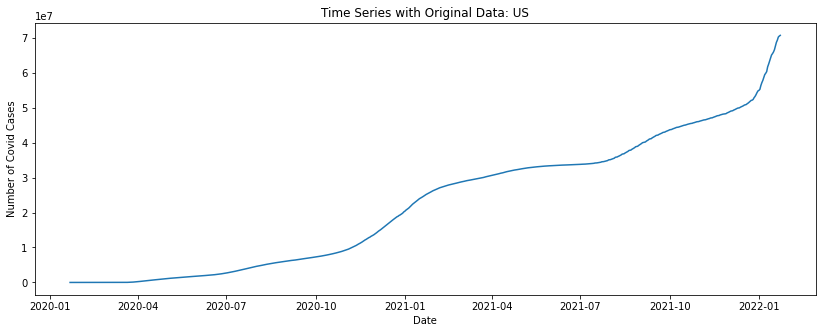

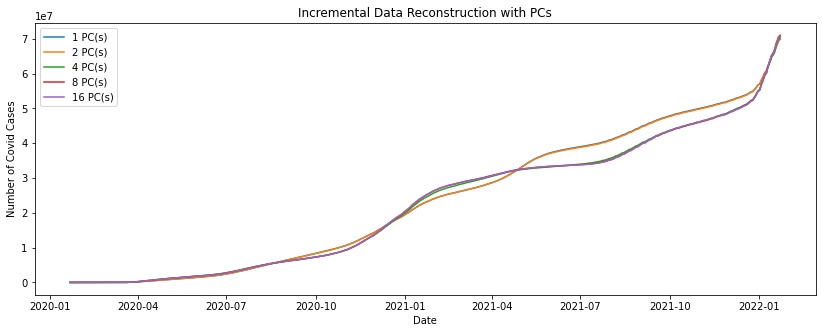

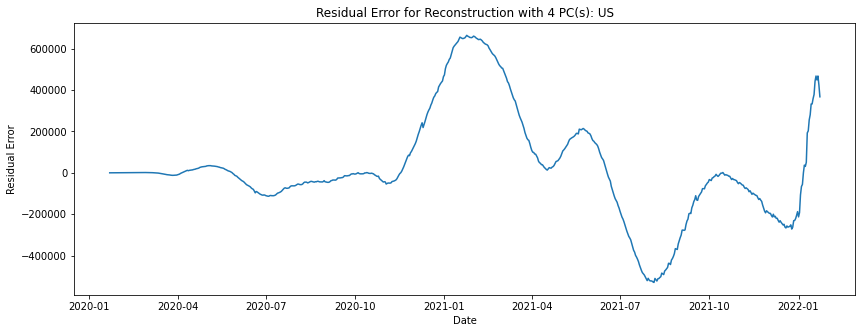

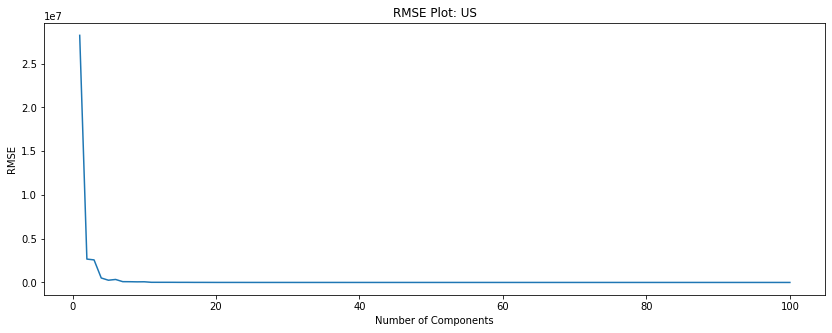

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For China


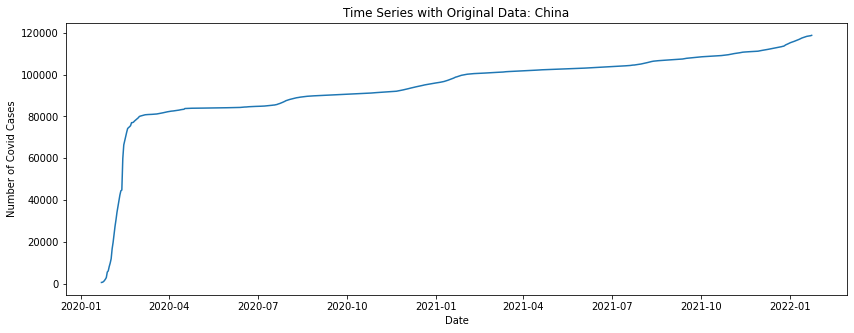

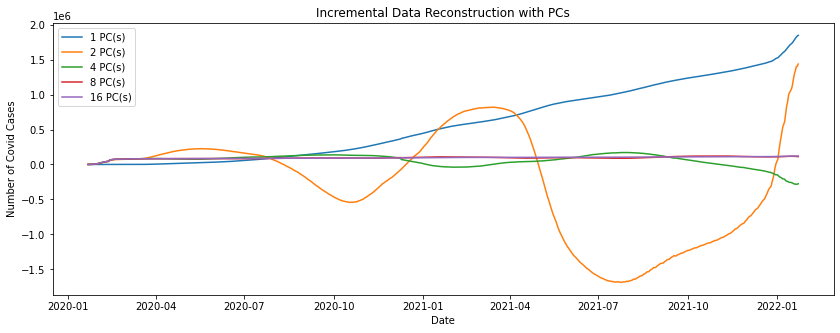

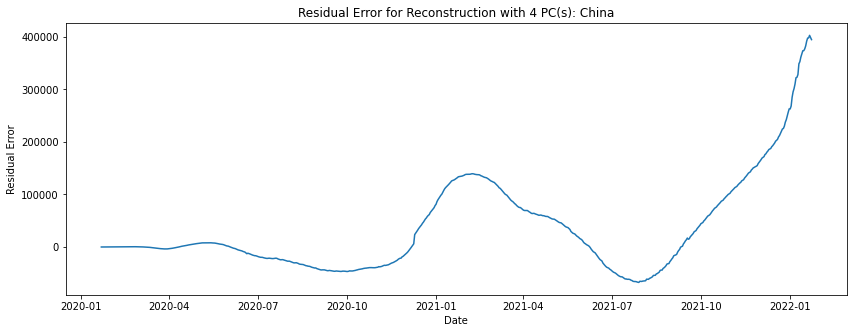

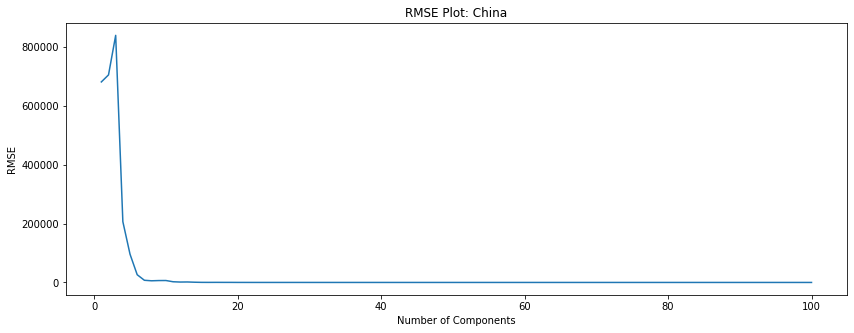

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For Canada


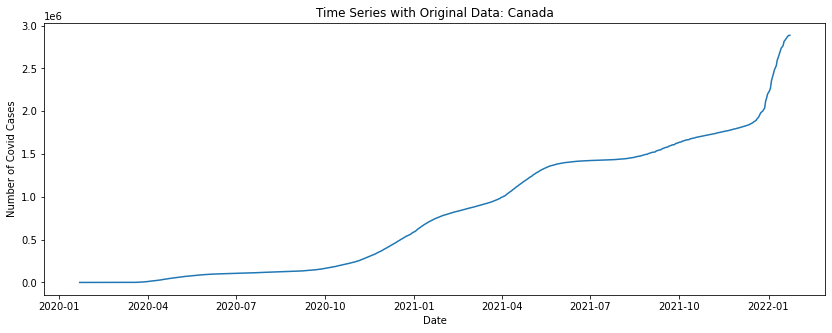

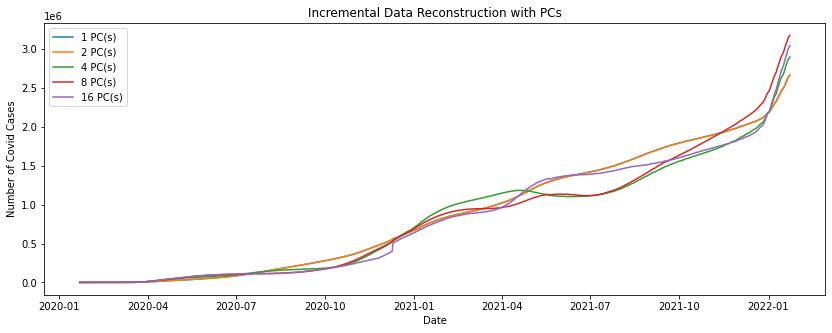

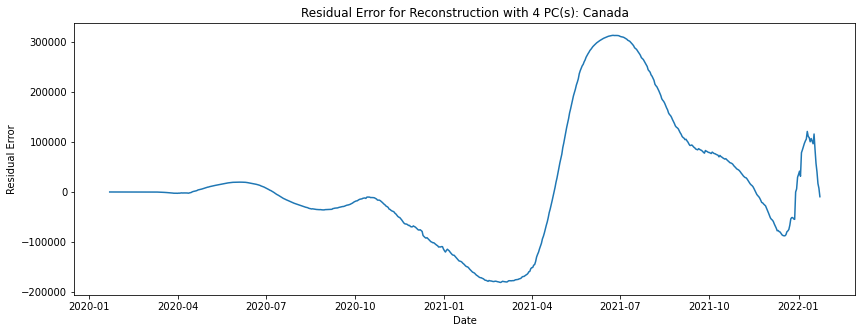

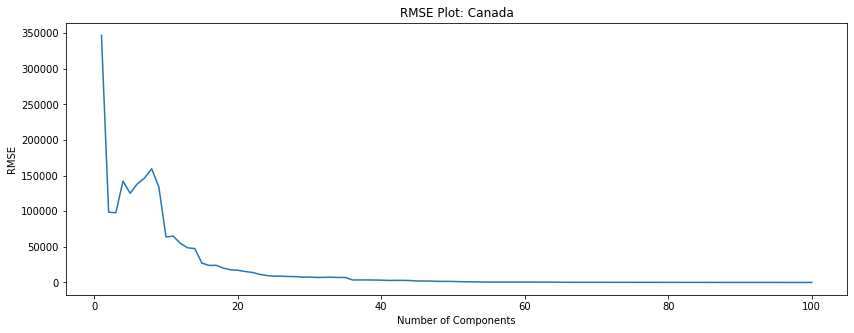

In [ ]:
for c_name in country_list:
  plot_country_figures(cases_raw, c_name)

## Singular Value Decomposition

In [ ]:
def svd_plot_country_figures(original_df, country_name):

  cases_raw_arr = original_df.iloc[::].values
  U, S, V = np.linalg.svd(cases_raw_arr, full_matrices = False)

  print('*-'*60)
  print('For {}'.format(country_name))

   # 1. plotting original time series
  plt.figure(figsize = (14,5))
  plt.plot(original_df.loc[country_name])
  plt.title('Time Series with Original Data: {}'.format(country_name))
  plt.xlabel('Date')
  plt.ylabel('Number of Covid Cases')
  plt.show()
  print()

  # 2. plotting reconstructed (non-standardized data) with different number of PCs
  pc_num = np.array([1,2,4,8,16])
  residual_errors = {}
  plt.figure(figsize = (14,5))
  for i in pc_num:
    U_plot = U[:, 0:i]
    V_plot = V[0:i, :]
    recon = (U_plot*S[0:i]) @ V_plot
    recon_df = pd.DataFrame(data = recon, columns = original_df.columns, index = original_df.index)
    plt.plot(recon_df.loc[country_name], label = '{} PC(s)'.format(i))
    
    residual_errors[i] = original_df.loc[country_name] - recon_df.loc[country_name]
  
  # print(residual_errors)
  plt.title('Incremental Data Reconstruction with PCs')
  plt.xlabel('Date')
  plt.ylabel('Number of Covid Cases')
  plt.legend()
  plt.show()
  print()

  # 3. plotting residual error for the best reconstruction
  plt.figure(figsize = (14,5))
  eigen_value_sum = sum(S**2)
  exp_variance = [(S**2/eigen_value_sum)*100 for eigen_val in S]
  cum_variance = np.cumsum(exp_variance)
  tr = np.where(cum_variance < 99)[0]   #considering atleast 99% variance as the best reconstruction
  tr_len = len(tr) + 1

  plt.plot(residual_errors.get(tr_len))
  plt.title('Residual Error for Reconstruction with {} PC(s): {}'.format(tr_len, country_name))
  plt.xlabel('Date')
  plt.ylabel('Residual Error')
  plt.show()
  print()

  # 4. plotting RMSE plot
  rmse = []
  plt.figure(figsize = (14,5))
  for k in range(0,100):
    U_plot = U[:, 0:k]
    V_plot = V[0:k, :]
    recon = (U_plot*S[0:k]) @ V_plot
    recon_df = pd.DataFrame(recon, columns = original_df.columns, index = original_df.index)
    rmse_value = np.sqrt((((original_df - recon_df).loc[country_name].values.ravel())**2).mean())
    rmse.append(rmse_value)
  plt.plot(range(1,101), rmse)
  plt.xlabel('Number of Components')
  plt.ylabel('RMSE')
  plt.title('RMSE Plot: {}'.format(country_name))
  plt.show()
  print()

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For US


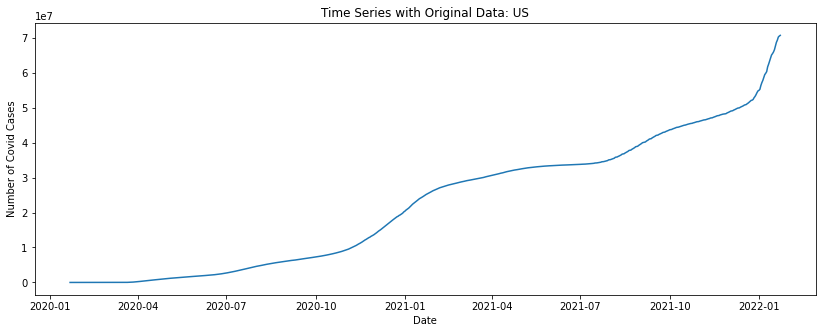

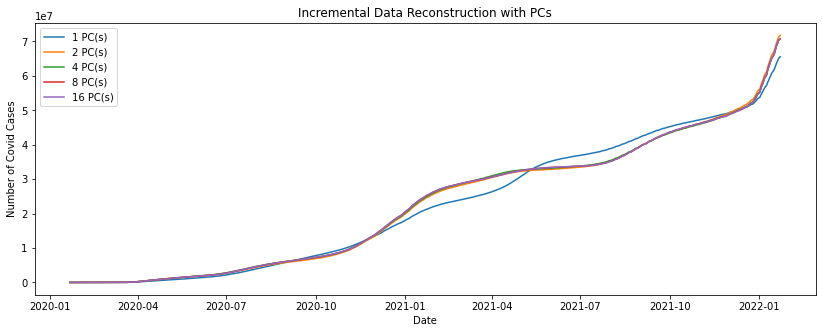

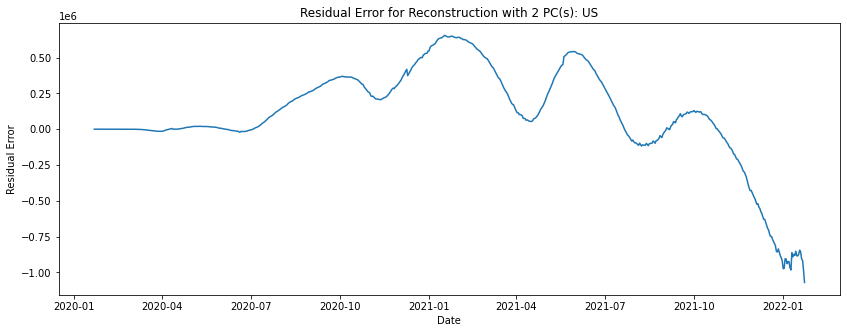

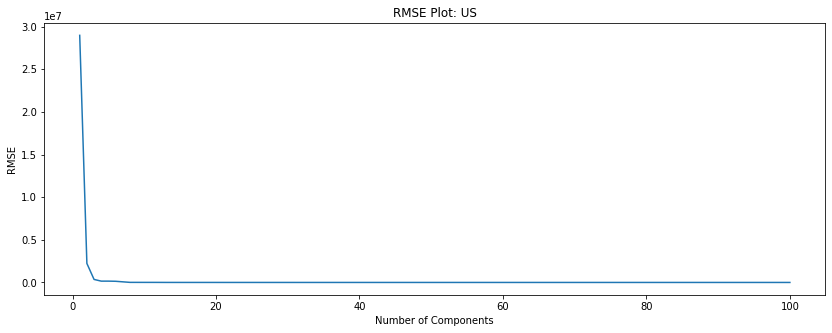


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For China


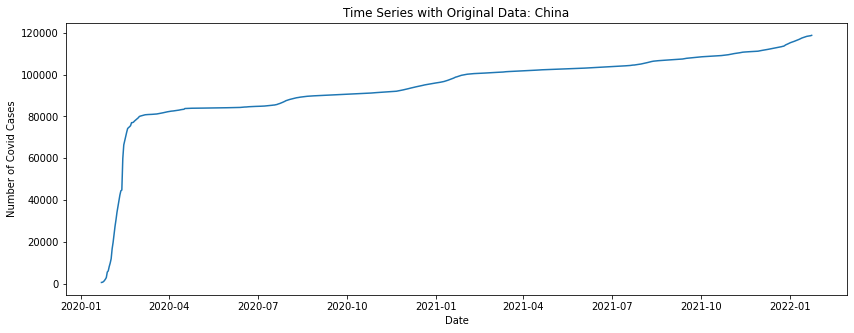

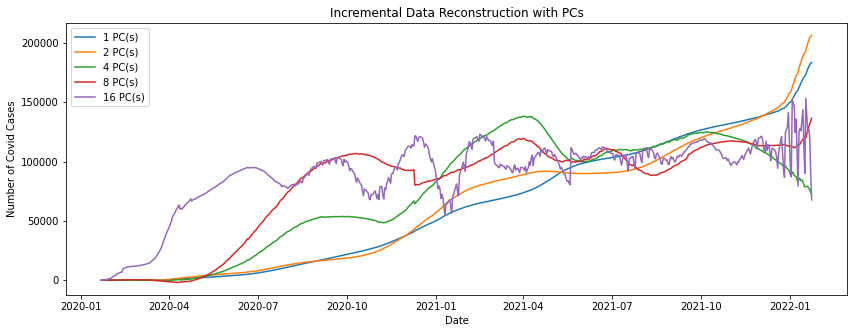

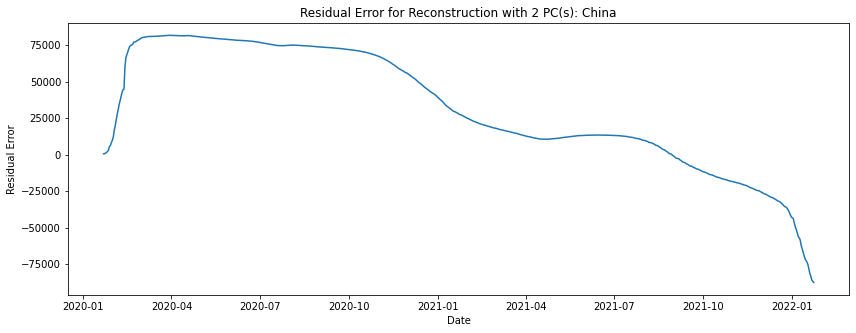

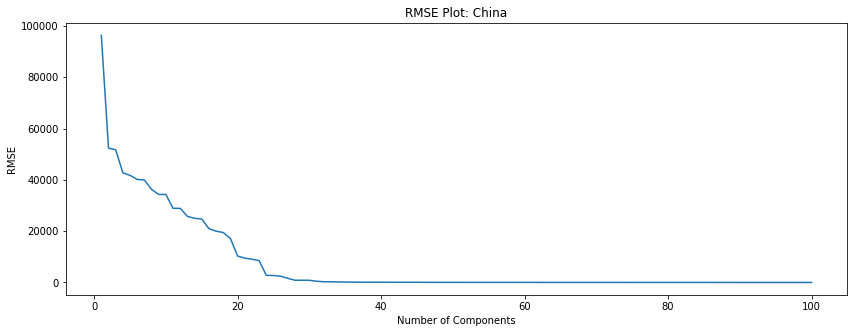


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For Canada


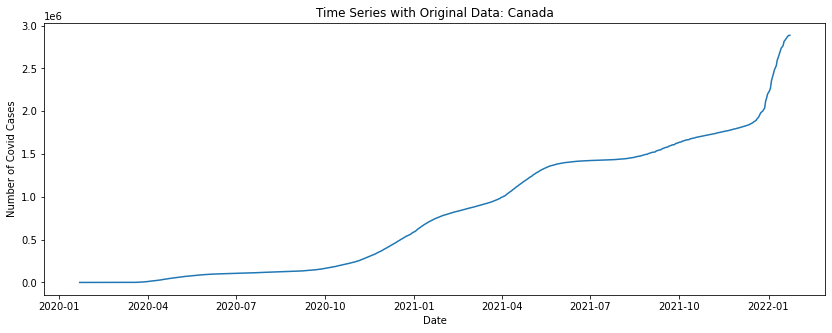

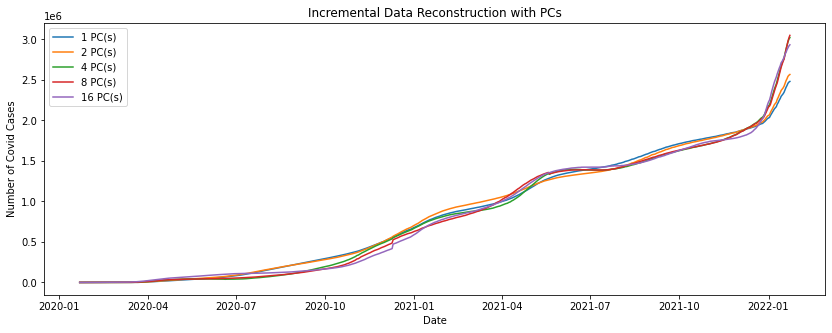

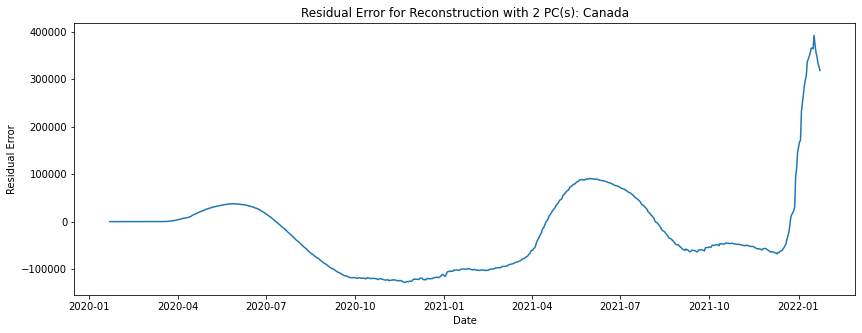

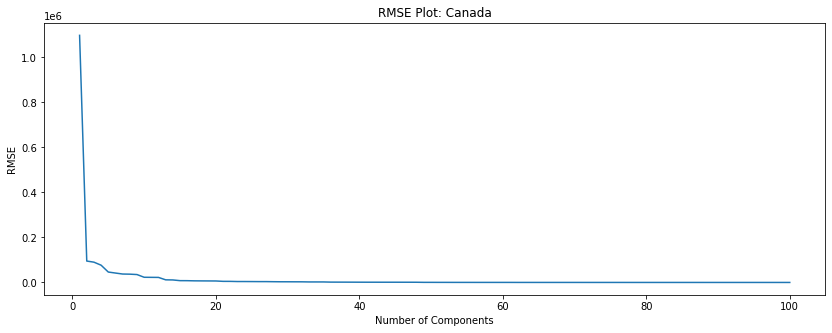

In [ ]:
for c_name in country_list:
  svd_plot_country_figures(cases_raw, c_name)

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For US


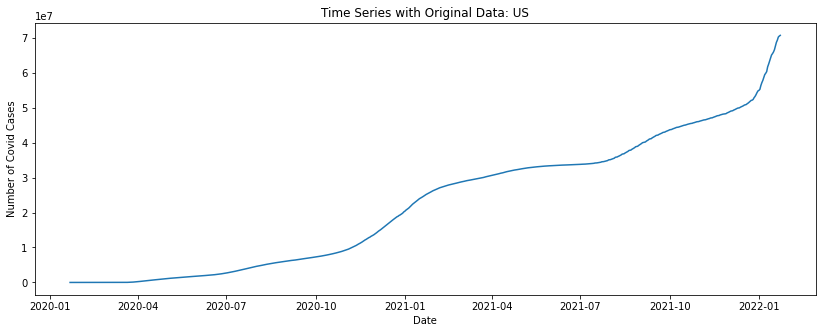

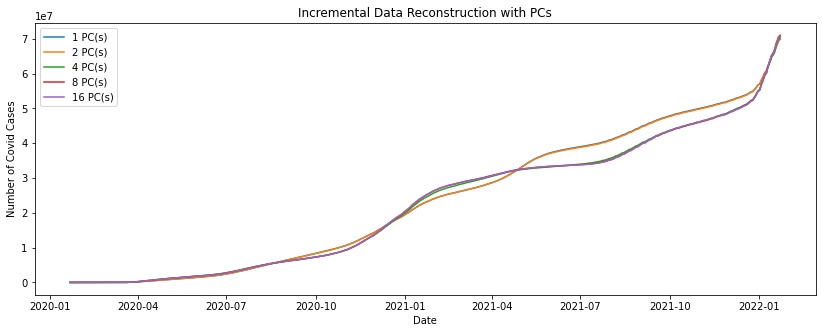

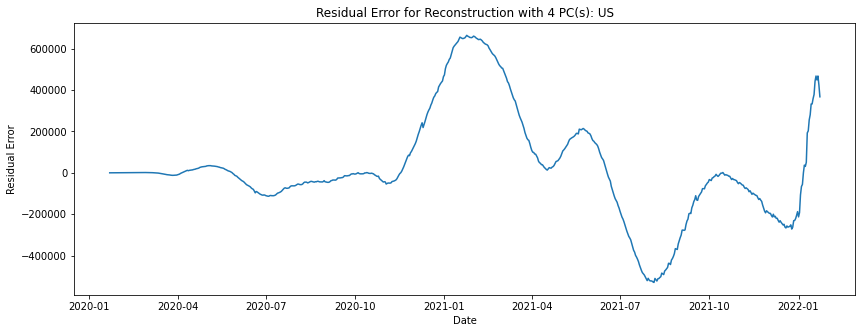

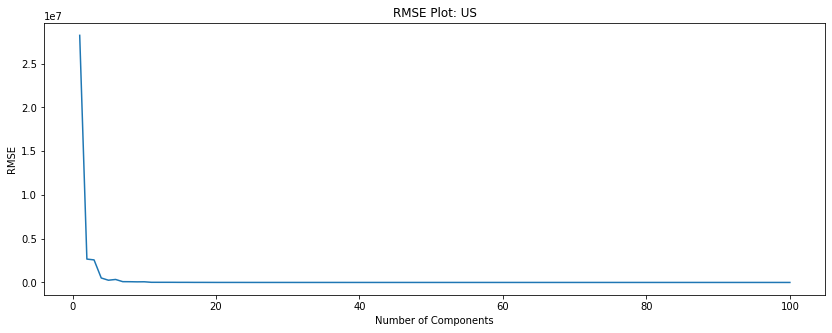

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For China


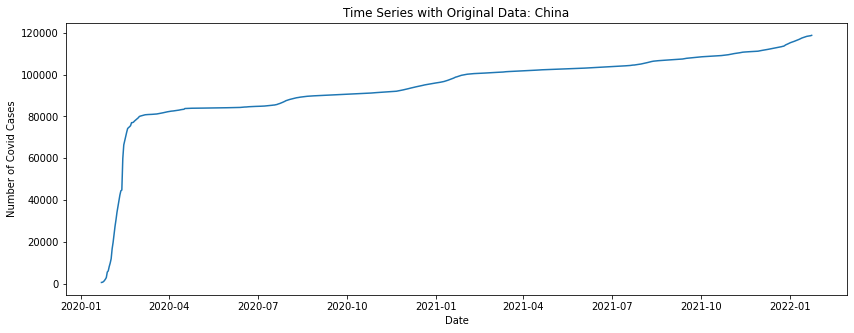

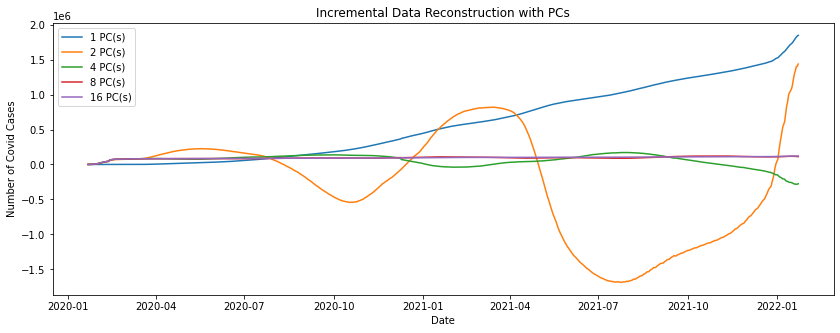

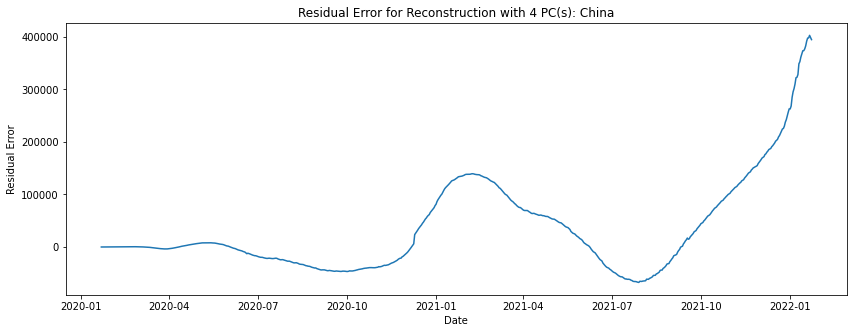

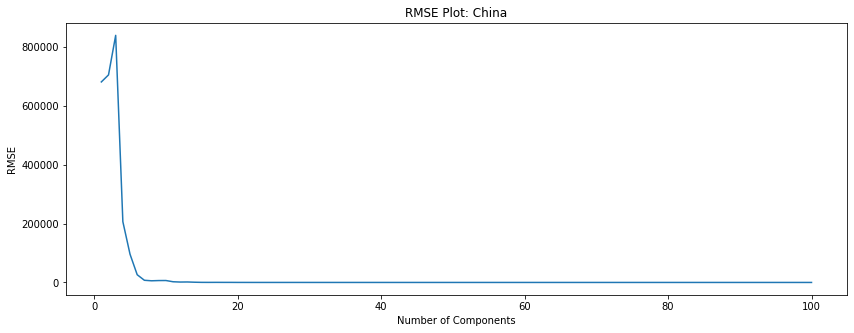

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
For Canada


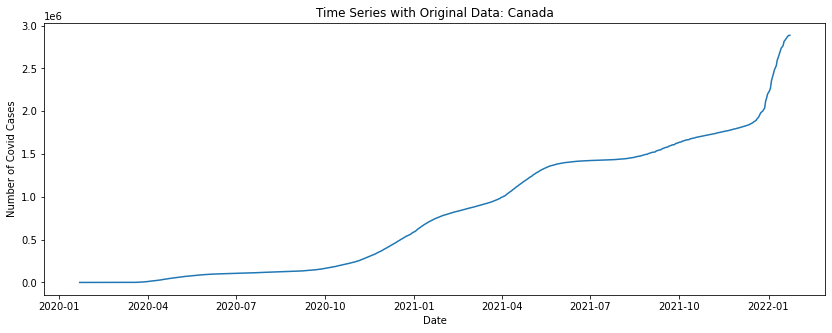

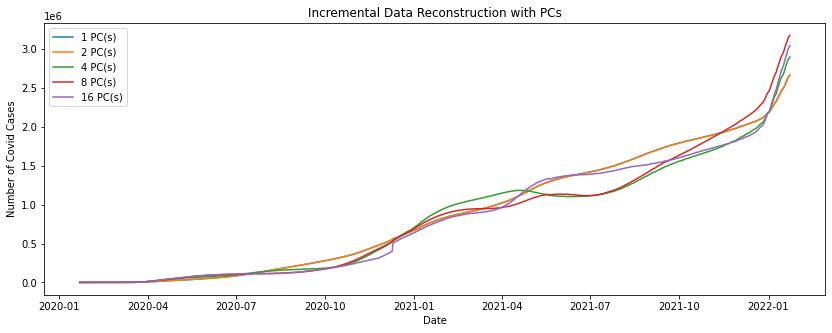

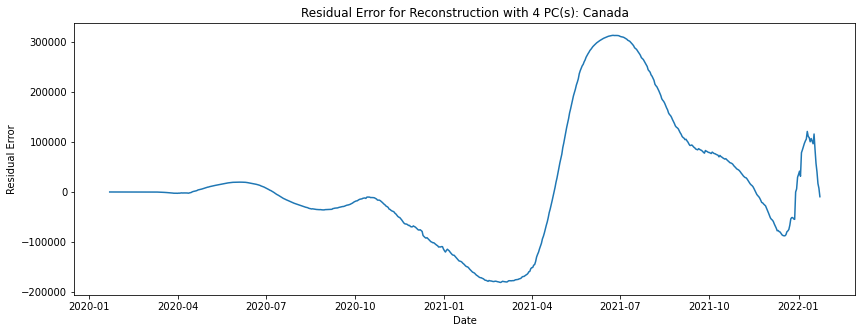

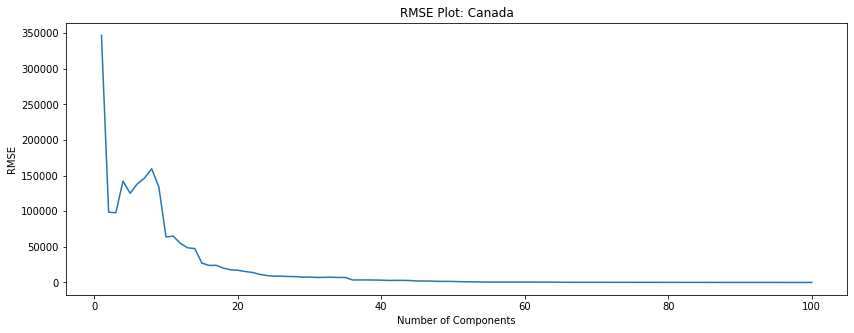

In [ ]:
# repeating part 3
for c_name in country_list:
  plot_country_figures(cases_raw, c_name)

## Which is Better - PCA or SVD?

When results from PCA and SVD are compared, we can see that the plots generated by both methods are very similar. The only difference observed is that the number of principal components required to capture high data variance is lower in SVD. Both methods decompose a matrix to obtain singular values/eigenvalues and singular vectors/eigenvectors. In SVD, the singular values are just the square root of eigenvalues from PCA. The eigenvectors in PCA are simply the transpose of the right singular vectors in SVD. Since, the overall idea of both methods are similar, the results obtained are also approximately the same